In [8]:
import pandas as pd

train_loss = [
    0.045552572654371355,
    0.043293155760902494,
    0.042884061317645945,
    0.042666319261879714,
    0.04255907804678535,
    0.042432036920164146,
    0.04234932652971398,
    0.042281313528406014,
]

val_loss = [
    0.046404985962687315,
    0.04616103762490743,
    0.04580690225160679,
    0.04548883599753169,
    0.04548084332037909,
    0.04527067876894585,
    0.045193105498534746,
    0.04520549797052541,    
]



df = pd.DataFrame()
# df['Epoch'] = list(range(8))
df['Train Loss'] = train_loss
df['Validation Loss'] = val_loss

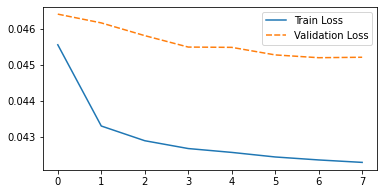

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


fig,ax = plt.subplots(figsize=(6,3))
sns.lineplot(
    data = df,
    # x='Epoch',
    # y='Train Loss'
    ax = ax
)
fig.savefig('plots/linear_encoder_loss.pdf')


# sns.lineplot(
#     data = df,
#     x='Epoch',
#     y='Validation Loss'
# )

In [15]:
from dataset import TwitterDataset


dset = TwitterDataset(
    'timestamp',
    'spam_idx.pkl',
    # whole_text_path,
    token_path = 'tokens/text',
    filter_spam = True
)


loading from timestamp:   0%|          | 0/221 [00:01<?, ?it/s]

loading tokens...:   0%|          | 0/221 [00:00<?, ?it/s]

loading from :   0%|          | 0/1 [00:00<?, ?it/s]

no spam here!
loaded dataset. took 140.01754926890135 ms. Got 20050096 items


In [16]:
from ngrams import count_grams
by_count = count_grams(dset, 1, ' ')

making 1 grams..:   0%|          | 0/20050096 [00:00<?, ?it/s]

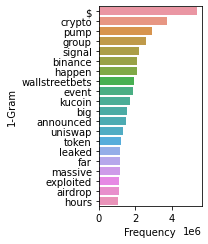

In [25]:
fig,ax = plt.subplots(figsize=(3,3.5))

df = pd.DataFrame(by_count[:20],columns=[f'{1}-Gram','Frequency'])
sns.barplot(
    data=df,
    x = 'Frequency',
    y = f'{1}-Gram',
    ax=ax
)
plt.tight_layout()